In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from datetime import datetime as dt

from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

In [2]:
def read_data():
    df_credits = pd.read_csv('../data/User Credits Student Access.csv', encoding='utf-8')
    df_atlas = pd.read_csv('../data/Atlas Cechu Student Access.csv', encoding='utf-8')
    df_payments = pd.read_csv('../data/Payments Student Access.csv', encoding='utf-8')
    return df_credits, df_atlas, df_payments


In [3]:
_, _, df_payments = read_data()

df_payments[(df_payments['user'].isna())&(df_payments['credits']>=500)]
df_payments[(df_payments['user'].isna())&(df_payments['credits']<500)]
df_payments[(df_payments['user'].isna())&(df_payments['credits'].isna())]

df_payments[df_payments['id'].isnull()]

,id,created_at,changed_at,user,batch,credits,state,type
1424,NaN,Anna,Prchalová,NaN,1299589028/3030,NaN,NaN,NaN


In [4]:
def data_cleaning(df_credits, df_payments):
    df_c_negative = df_credits[df_credits['credits']<0]
    df_credits[df_credits.user.isin(df_c_negative.user) == True]

    # IDK what I'm doing with payments
    df_payments[df_payments.user.isin(df_c_negative.user)==True].sort_values(['user','created_at'])
    df_payments.state.unique()
    df_payments[df_payments.user=='STUD54678']
    df_credits[df_credits.user=='STUD54678']

    df_credits_cleaned = df_credits[df_credits['credits']>0]
    df_payments_cleaned = df_payments[df_payments['user'].notna()] # we threw out from payments 2345 observations

    return df_credits_cleaned, df_payments_cleaned


In [5]:
def get_merged_table():
    df_credits, df_atlas, df_payments = read_data()
    _, df_payments_cleaned = data_cleaning(df_credits, df_payments)
    df_merge_full = pd.merge(df_payments_cleaned, df_atlas, how='inner', left_on='user', right_on='user_id')
    df_merge_full.rename(columns={'credits_x':'credits_payments', 'credits_y':'credits_credits'})
    df_merge_full = pd.get_dummies(df_merge_full, columns=['type'], drop_first=True)
    df_merge_full = df_merge_full.astype({col: int for col in df_merge_full.select_dtypes(include='bool').columns})

    df_merge_full['created_at'] = pd.to_datetime(df_merge_full['created_at'])

    df_merge_full['day'] = df_merge_full['created_at'].dt.day
    df_merge_full['month'] = df_merge_full['created_at'].dt.month
    df_merge_full['year'] = df_merge_full['created_at'].dt.year
    df_merge_full['hour'] = df_merge_full['created_at'].dt.hour
    df_merge_full['weekday'] = df_merge_full['created_at'].dt.weekday


    df_merge_full = df_merge_full.drop(columns=['created_at'])
    return df_merge_full

df_merge_full = get_merged_table()

/var/folders/_c/8b17td616wg63_3tyjv1dhb80000gn/T/ipykernel_75122/372274628.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merge_full['day'] = df_merge_full['created_at'].dt.day
/var/folders/_c/8b17td616wg63_3tyjv1dhb80000gn/T/ipykernel_75122/372274628.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_merge_full['month'] = df_merge_full['created_at'].dt.month
/var/folders/_c/8b17td616wg63_3tyjv1dhb80000gn/T/ipykernel_75122/372274628.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the res

In [6]:
# split dataset into three categories
def get_split_values(df_merge_full, value:int):
    col_name = f'credits_{value}+'
    df_modeling = df_merge_full.drop(columns=['id', 'changed_at', 'user', 'batch', 'state', 'user_id'])
    df_modeling[col_name] = (df_modeling['credits'] > value).astype(int)
    df_modeling = df_modeling.drop(columns=['credits'])

    fig = px.bar(pd.DataFrame(df_modeling[col_name].value_counts().reset_index()), x=col_name, y='count', title='Credits Category Distribution')
    fig.show()
    
    df_modeling = df_modeling[df_modeling[col_name].isnull()==False] # clean data from null values
    return df_modeling, col_name

df_modeling, colname = get_split_values(df_merge_full, 660)

/var/folders/_c/8b17td616wg63_3tyjv1dhb80000gn/T/ipykernel_75122/1944506396.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_modeling[col_name] = (df_modeling['credits'] > value).astype(int)


In [7]:
y = df_modeling[colname]
X = df_modeling.drop(columns=[colname])

def split_data(X, y, test_size=0.2, stratify=True, random_state=42):
    """
    Split data into training and testing sets with optional stratification.

    Args:
        X (pd.DataFrame): Feature matrix.
        y (pd.Series): Target variable.
        test_size (float): Proportion of data to use as test set.
        stratify (bool): Whether to stratify split based on y.
        random_state (int): Seed for reproducibility.

    Returns:
        Tuple: (X_train, X_test, y_train, y_test)s
    """
    return train_test_split(
        X,
        y,
        test_size=test_size,
        stratify=y if stratify else None,
        random_state=random_state
    )

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y , train_size=0.8, random_state=42)

def get_smote_train(X_train, y_train):
    smote = SMOTE(random_state=42)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    return X_train_smote, y_train_smote

X_train_smote, y_train_smote = get_smote_train(X_train, y_train)

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.



# Modeling

# Grid Search

In [8]:
# catboost clf

grid_cat = {
    'depth':np.array(range(3, 12, 3)),
    'learning_rate': np.array(range(5, 15, 5))/100,
    'loss_function':['CrossEntropy','Logloss'],
}

model_cat = CatBoostClassifier(
    iterations=1500,
    eval_metric='Accuracy',
    verbose=200 # control how often the model will print out output - e.g. when verbose is set to 50 = every 50 iteretion print out current status
)

grid_cat = RandomizedSearchCV(estimator=model_cat, param_distributions=grid_cat, cv=None, scoring='accuracy', n_iter=10, n_jobs=-1)
grid_cat.fit(X_train_smote, y_train_smote)

KeyboardInterrupt: 

In [220]:
grid_cat.best_params_

{'loss_function': 'CrossEntropy',
 'learning_rate': np.float64(0.05),
 'depth': np.int64(9)}

In [250]:
model_cat_test = CatBoostClassifier(
    iterations=900,
    eval_metric='Accuracy',
    verbose=300, # control how often the model will print out output - e.g. when verbose is set to 50 = every 50 iteretion print out current status
    learning_rate=0.1,
    loss_function='CrossEntropy', 
    depth=6
)

model_cat_test.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 0.7992838	test: 0.7987351	best: 0.7987351 (0)	total: 18.3ms	remaining: 16.5s
300:	learn: 0.8663442	test: 0.8206845	best: 0.8225446 (286)	total: 4s	remaining: 7.95s
600:	learn: 0.9185230	test: 0.8271949	best: 0.8273810 (595)	total: 8.01s	remaining: 3.98s
899:	learn: 0.9539134	test: 0.8249628	best: 0.8273810 (595)	total: 11.9s	remaining: 0us

bestTest = 0.8273809524
bestIteration = 595

Shrink model to first 596 iterations.


In [251]:
y_pred = model_cat_test.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.97      0.90      4297
           1       0.69      0.26      0.38      1079

    accuracy                           0.83      5376
   macro avg       0.76      0.61      0.64      5376
weighted avg       0.81      0.83      0.79      5376



In [194]:
# XGBClassifier

xgb.set_config(verbosity=1)

param_grid = {
    'n_estimators': np.array(range(100, 2000, 100)),
    'max_depth': np.array(range(1, 20, 1)),
    'learning_rate': np.array(range(5, 25, 5))/100,
    'eval_metric': ['logloss', 'error', 'auc'],
}

model = XGBClassifier(objective='binary:logistic', use_label_encoder=False)

grid_XGB = RandomizedSearchCV(model, param_grid, cv=None, scoring='accuracy', n_iter=10, n_jobs=-1)
grid_XGB.fit(X_train_smote, y_train_smote)

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:36:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:36:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [11:36:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'eval_metric': ['logloss', 'error',
                                                        'auc'],
                                        'learning_rate': array([0.05, 0.1 , 0.15, 0.2 ]),
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900])},
                   scoring='accuracy')

In [195]:
##### logistic regression model
model_logit = LogisticRegression()
model_logit.fit(X_train_smote, y_train_smote)

##### Decision Tree
param_grid = {
    'max_depth': np.array(range(1, 20, 1)),
    'criterion': ['gini', 'entropy']
}

model_dt = DecisionTreeClassifier(random_state=42)

grid_dt = RandomizedSearchCV(model_dt, param_grid, cv=None, scoring='accuracy', n_iter=10)
grid_dt.fit(X_train_smote, y_train_smote)

##### Random Forest
param_grid = {
    'n_estimators': np.array(range(100, 2000, 100)),
    'max_depth': np.array(range(1, 20, 1)),
    'criterion': ['gini', 'entropy']
}

model_rf = RandomForestClassifier(random_state=42)

grid_rf = RandomizedSearchCV(model_rf, param_grid, cv=None, scoring='accuracy', n_iter=10)
grid_rf.fit(X_train_smote, y_train_smote)

/Users/vanhieuvu/Documents/school/Magisterský studium/2.semestr/datovy_projekt/dp_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100,
       1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900])},
                   scoring='accuracy')

In [228]:
grid_rf.best_params_

{'n_estimators': np.int64(1000),
 'max_depth': np.int64(19),
 'criterion': 'gini'}

In [13]:
model_rf_test = RandomForestClassifier(n_estimators=1000, max_depth=30, criterion='gini')
model_rf_test.fit(X_train_smote, y_train_smote)

RandomForestClassifier(max_depth=30, n_estimators=1000)

In [14]:
model_rf_test
print(classification_report(y_test, model_rf_test.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4297
           1       0.56      0.42      0.48      1079

    accuracy                           0.82      5376
   macro avg       0.71      0.67      0.68      5376
weighted avg       0.80      0.82      0.81      5376



In [196]:
grid_rf.best_params_

{'n_estimators': np.int64(1000),
 'max_depth': np.int64(19),
 'criterion': 'gini'}

In [201]:
best_dt = grid_dt.best_estimator_
best_rf = grid_rf.best_estimator_
best_cat = grid_cat.best_estimator_
best_XGB = grid_XGB.best_estimator_

In [213]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

def evaluate_model_separate(list_model, list_model_name, X_test, y_test):
    """
    Evaluates classification models and returns:
    - DataFrame with metrics for class '0' and '1'
    - DataFrame with overall accuracy per model
    - Dictionary with confusion matrices per model

    Parameters:
    - list_model: list of trained model objects
    - list_model_name: list of corresponding model names
    - X_test: test features
    - y_test: test labels

    Returns:
    - df_class: DataFrame with metrics for class '0' and '1'
    - df_accuracy: DataFrame with overall accuracy per model
    - cm_dict: Dictionary of confusion matrices {model_name: matrix}
    """
    class_rows = []
    accuracy_rows = []
    cm_dict = {}

    for model, name in zip(list_model, list_model_name):
        y_pred = model.predict(X_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        cm = confusion_matrix(y_test, y_pred)
        cm_dict[name] = cm  # store confusion matrix in dictionary

        for label, metrics in report.items():
            if label in ['0', '1']:
                class_rows.append({
                    'model': name,
                    'class': label,
                    'precision': metrics['precision'],
                    'recall': metrics['recall'],
                    'f1-score': metrics['f1-score'],
                    'support': metrics['support']
                })
            elif label == 'accuracy':
                accuracy_rows.append({
                    'model': name,
                    'accuracy': metrics
                })

    df_class = pd.DataFrame(class_rows)
    df_accuracy = pd.DataFrame(accuracy_rows)
    return df_class, df_accuracy, cm_dict

In [216]:
list_model = [model_logit, best_dt, best_rf, best_cat, best_XGB]
list_model_name = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'CatBoost', 'XGBoost']

df_class, df_accuracy, cm_dict = evaluate_model_separate(list_model, list_model_name, X_test, y_test)

In [219]:
df_class

,model,class,precision,recall,f1-score,support
0,Logistic Regression,0,0.814379,0.901559,0.855754,4297.0
1,Logistic Regression,1,0.316640,0.181650,0.230860,1079.0
2,Decision Tree,0,0.851165,0.833139,0.842056,4297.0
3,Decision Tree,1,0.387179,0.419833,0.402846,1079.0
4,Random Forest,0,0.868345,0.907145,0.887321,4297.0
5,Random Forest,1,0.550169,0.452271,0.496439,1079.0
6,CatBoost,0,0.842922,0.947871,0.892321,4297.0
7,CatBoost,1,0.588235,0.296571,0.394331,1079.0
8,XGBoost,0,0.853441,0.935071,0.892393,4297.0
9,XGBoost,1,0.582335,0.360519,0.445335,1079.0


In [217]:
cm_dict

{'Logistic Regression': array([[3874,  423],
        [ 883,  196]]),
 'Decision Tree': array([[3580,  717],
        [ 626,  453]]),
 'Random Forest': array([[3898,  399],
        [ 591,  488]]),
 'CatBoost': array([[4073,  224],
        [ 759,  320]]),
 'XGBoost': array([[4018,  279],
        [ 690,  389]])}

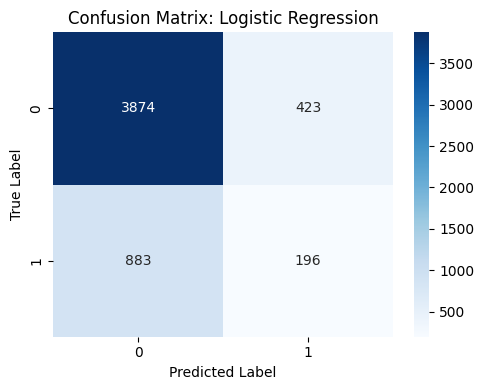

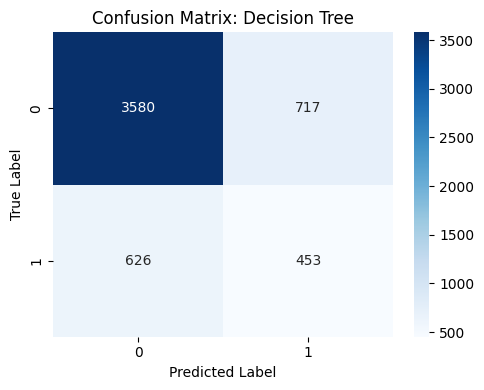

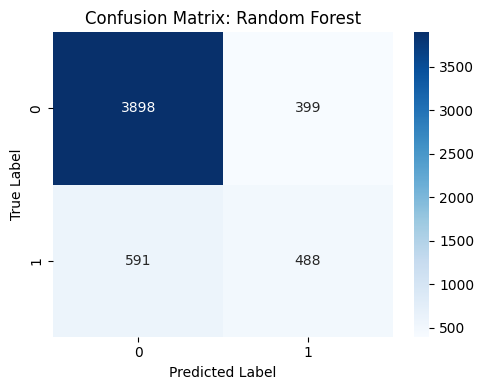

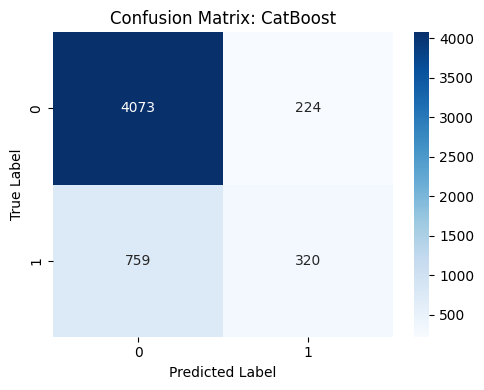

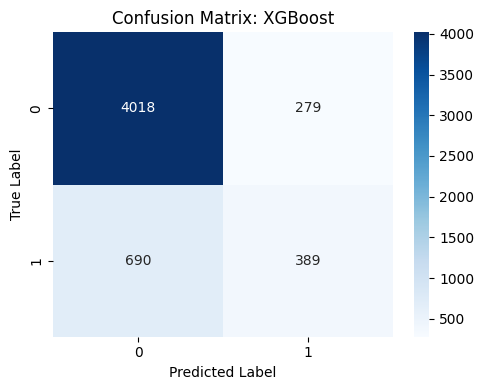

In [218]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrices(cm_dict, class_labels=['0', '1']):
    """
    Plots confusion matrices stored in a dictionary using Seaborn heatmaps.

    Parameters:
    - cm_dict: Dictionary of {model_name: confusion_matrix}
    - class_labels: List of class labels (default ['0', '1'])
    """
    for model_name, cm in cm_dict.items():
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix: {model_name}')
        plt.tight_layout()
        plt.show()

df_class, df_accuracy, cm_dict = evaluate_model_separate(list_model, list_model_name, X_test, y_test)
plot_confusion_matrices(cm_dict)